# Image Stitching

In [1]:
import numpy as np
import imutils
import cv2

class Stitcher:
    def __init__(self):
        pass
        
    def stitch(self, imageA, imageB, ratio=.75, reproj_thresh=4.0):
        
        # extract local invariant descriptors from the images.
        (kpsA, featuresA) = self.detect_keypoints_and_features(imageA)
        (kpsB, featuresB) = self.detect_keypoints_and_features(imageB)

        # match features between the two images
        matches = self.match_features(featuresA, featuresB, ratio)
        H, status = self.estimate_homography_matrix(kpsA, kpsB, matches, reproj_thresh)
        
        # Apply a perspective warp to the image B
        result = cv2.warpPerspective(imageB, H,
                                     (imageA.shape[1] + imageB.shape[1], imageB.shape[0]))
        result[0:imageA.shape[0], 0:imageA.shape[1]] = imageA # image A stays the same
        
        vis = self.visualize_matches(imageA, imageB, kpsA, kpsB, matches, status)
        return (result, vis)
        

    def detect_keypoints_and_features(self, image):
        """
        detects keypoints and extracts local invariant descriptors.
        
        keypoint detector: difference of gaussian (DoG)
        https://www.cs.utexas.edu/~grauman/courses/fall2009/papers/local_features_synthesis_draft.pdf
        
        feature extractor: Scale-invariant feature transform (SIFT)
        https://en.wikipedia.org/wiki/Scale-invariant_feature_transform
        """
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # using OpenCV 4
        descriptor = cv2.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)

        # convert the keypoints from KeyPoint objects to NumPy
        kps = np.float32([kp.pt for kp in kps])
        
        return (kps, features)
    
    def match_features(self, featuresA, featuresB, ratio):
        """
        Args:
        - featuresA, featuresB: Feature vectors associated with the image A and B
        - ratio: David Lowe's ratio test variable
        """
        # exhaustively compute the Euclidean distance between all feature vectors
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresB, featuresA, k=2)
        
        matches = []
        # loop over the raw matches
        for m in rawMatches:
            # Lowe's ratio test to determine high-quality feature matches. [0.7, 0.8].
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))
        return matches
                
    def estimate_homography_matrix(self, kpsA, kpsB, matches, reproj_thresh):
        """
        Args:
        - kpsA, kpsB: keypoints from image A and B
        - matches: Pairs of the matched keypoints
        - reprojThresh: RANSAC re-projection threshold
        """
        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            ptsA = np.float32([kpsA[i] for (i, _) in matches])
            ptsB = np.float32([kpsB[i] for (_, i) in matches])
            
            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, reproj_thresh)
            return (H, status)
        else:
            # otherwise, homography matrix cannot be computed
            raise ValueError('computing a homography requires at least 4 matches')
    
    def visualize_matches(self, imageA, imageB, kpsA, kpsB, matches, status):
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB
        
        # draw a red line for each matche
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            if s == 1:
                ptA = (int(kpsA[trainIdx][0]), int(kpsA[trainIdx][1]))
                ptB = (int(kpsB[queryIdx][0]) + wA, int(kpsB[queryIdx][1]))
                cv2.line(vis, ptB, ptA, (0, 0, 255), 1)
        return vis

In [61]:
import imutils

orig = cv2.imread('uci_campus.jpg')
imageA = cv2.imread('uci_0.png')
imageB = cv2.imread('uci_1.png')
imageC = cv2.imread('uci_2.png')
imageD = cv2.imread('uci_3.png')
imageE = cv2.imread('uci_4.png')
orig = imutils.resize(orig, height=400)
imageA = imutils.resize(imageA, height=200)
imageB = imutils.resize(imageB, height=200)
imageC = imutils.resize(imageC, height=200)
imageD = imutils.resize(imageD, height=200)
imageE = imutils.resize(imageE, height=400)

# stitch the images together to create a panorama
stitcher = Stitcher()

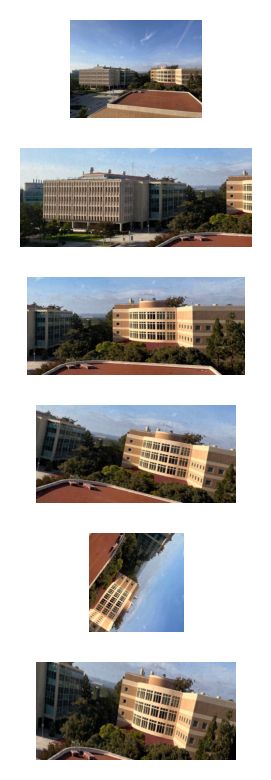

In [63]:
from matplotlib import pyplot as plt

ax0 = plt.subplot(611)
ax1 = plt.subplot(612)
ax2 = plt.subplot(613)
ax3 = plt.subplot(614)
ax4 = plt.subplot(615)
ax5 = plt.subplot(616)

ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')

ax0.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
ax1.imshow(cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB))
ax3.imshow(cv2.cvtColor(imageC, cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(imageE, cv2.COLOR_BGR2RGB))
ax5.imshow(cv2.cvtColor(imageD, cv2.COLOR_BGR2RGB))


plt.tight_layout()
plt.show()

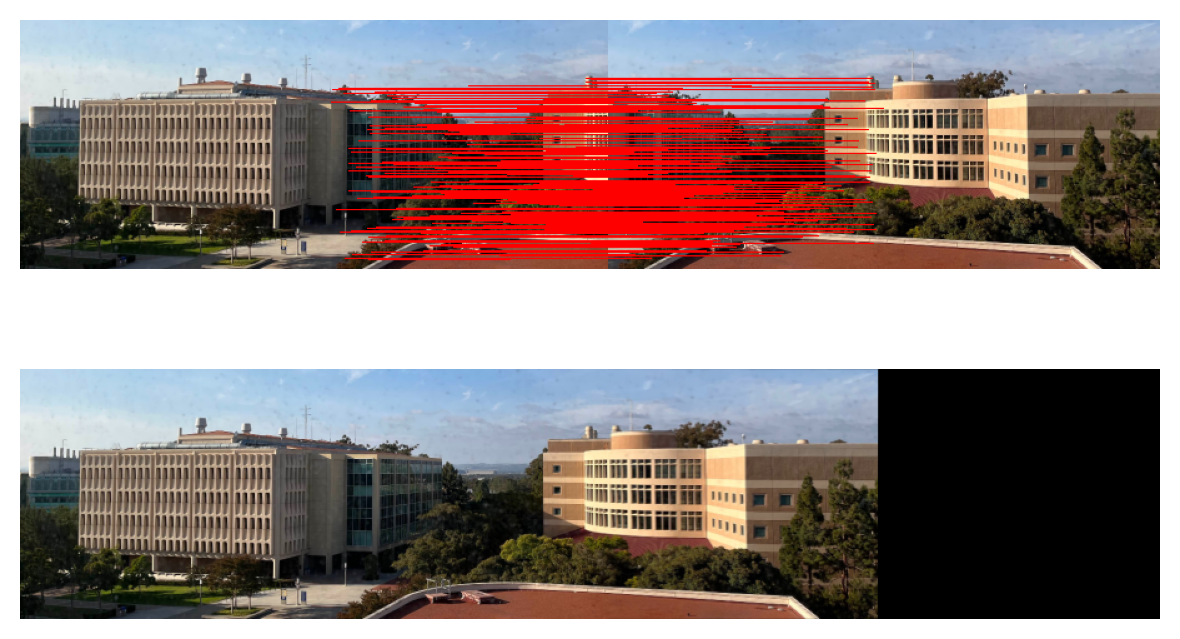

In [56]:
(result, vis) = stitcher.stitch(imageA, imageB)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.axis('off')
ax2.axis('off')

ax1.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

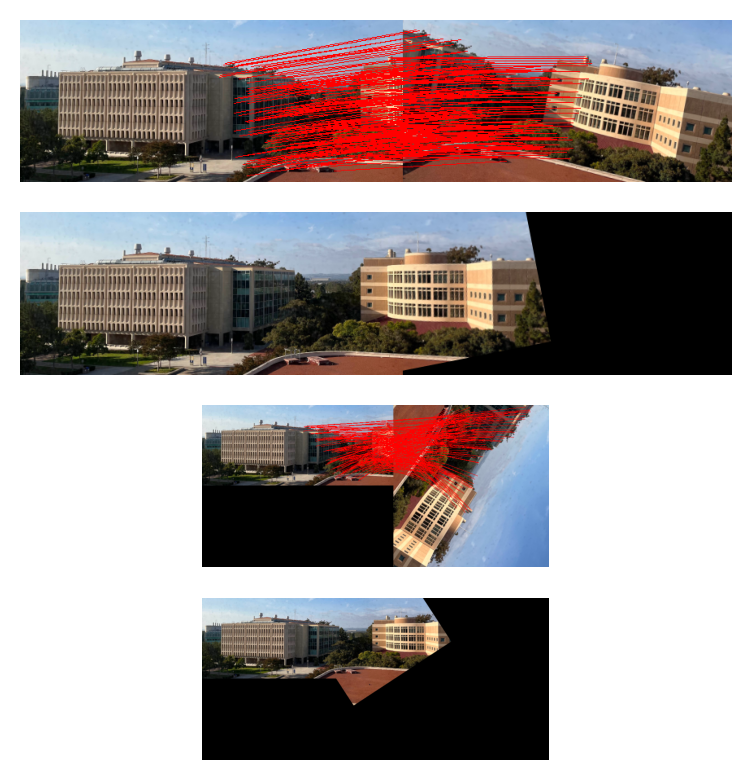

In [68]:
(result, vis) = stitcher.stitch(imageA, imageC)
ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

ax1.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

(result, vis) = stitcher.stitch(imageA, imageE)

ax3.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

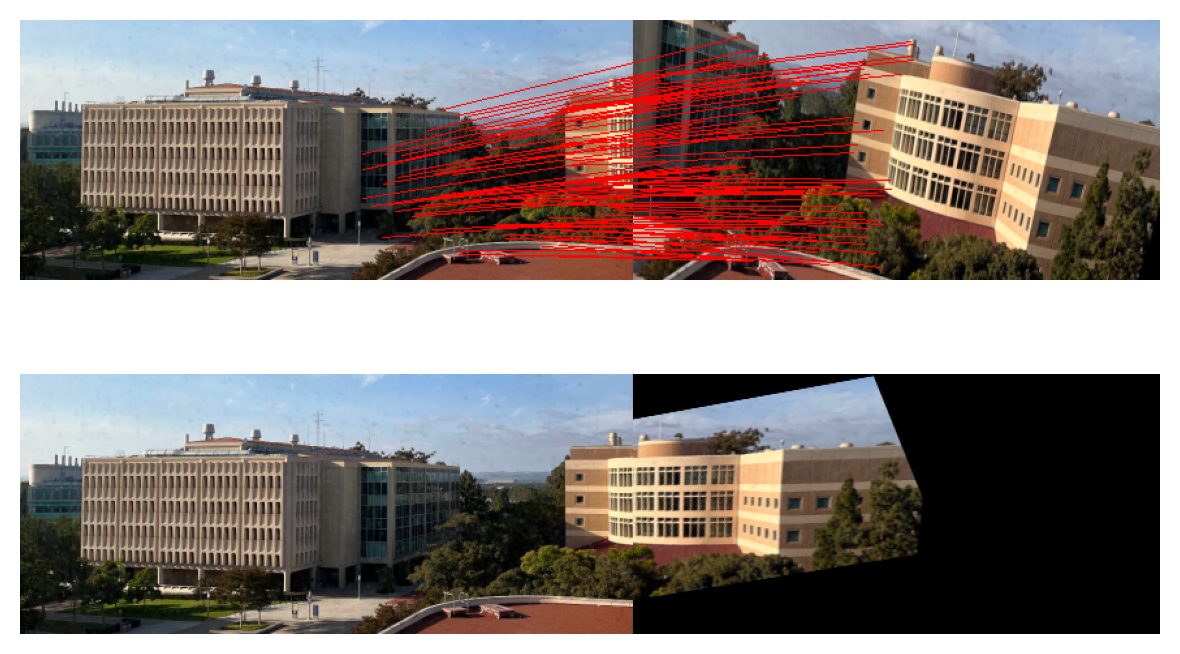

In [58]:
(result, vis) = stitcher.stitch(imageA, imageD)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.axis('off')
ax2.axis('off')

ax1.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

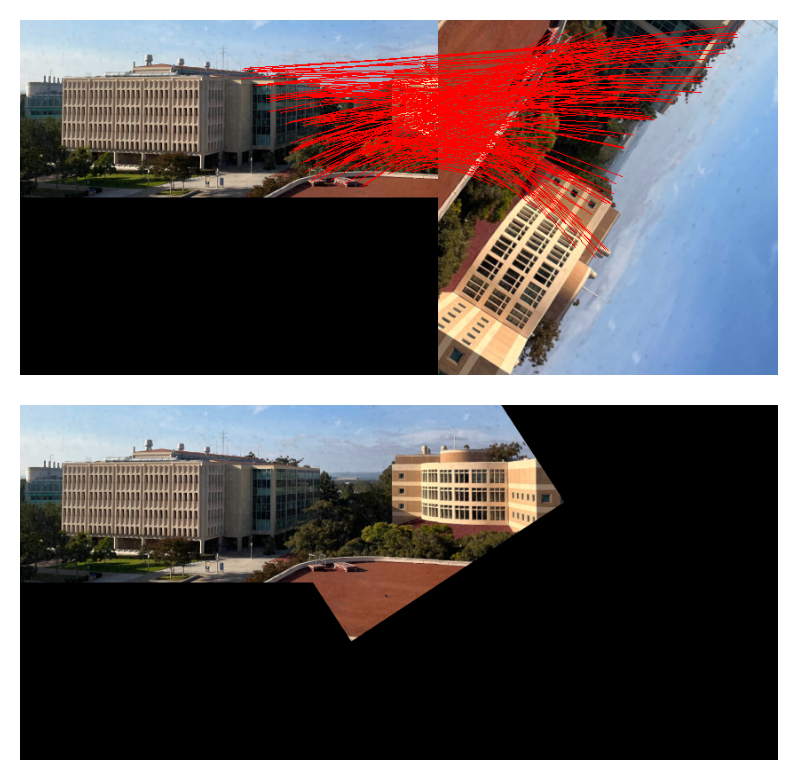

In [ ]:
(result, vis) = stitcher.stitch(imageA, imageE)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.axis('off')
ax2.axis('off')

ax1.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

In [59]:
# # save the images
# cv2.imwrite('keypoint_matches.png', vis)
# cv2.imwrite('stitched.png', result)